In [1]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define parent path & imports

In [2]:
import os
import sys
import shutil
import warnings
warnings.filterwarnings("ignore")
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


# Clone and install GroundingDINO

In [3]:
%cd {HOME}
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!git checkout -q 57535c5a79791cb76e36fdb64975271354f10251
!pip install -q -e .

/content
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 401, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 401 (delta 51), reused 44 (delta 44), pack-reused 325
Receiving objects: 100% (401/401), 12.84 MiB | 9.79 MiB/s, done.
Resolving deltas: 100% (204/204), done.
/content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.8 MB/s eta 0:00:00


# Install SAM

In [4]:
%cd {HOME}
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-r0rgtp3r
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-r0rgtp3r
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=b08a2cf1ed45d7d2de4cdec464bc77866e9bcaa65bf2f2b9f0f19a624b830975
  Stored in directory: /tmp/pip-ephem-wheel-cache-rkam0_vh/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


# Install supervision kit

In [5]:
!pip uninstall -y supervision
!pip install -q supervision==0.6.0

import supervision as sv
print(sv.__version__)

Found existing installation: supervision 0.4.0
Uninstalling supervision-0.4.0:
  Successfully uninstalled supervision-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
groundingdino 0.1.0 requires supervision==0.4.0, but you have supervision 0.6.0 which is incompatible.
0.6.0


# GroundingDINO weights

In [6]:
GROUNDING_DINO_CONFIG_PATH = os.path.join(HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(HOME, "weights", "groundingdino_swint_ogc.pth")


/content
/content/weights


# SAM weights

In [7]:
%cd {HOME}
!mkdir -p {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
SAM_CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")

/content
/content/weights


# Grounding DINO Model

In [8]:
%cd {HOME}/GroundingDINO

from groundingdino.util.inference import Model

grounding_dino_model = Model(model_config_path=GROUNDING_DINO_CONFIG_PATH, model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH)

/content/GroundingDINO
final text_encoder_type: bert-base-uncased


# SAM Model

In [9]:
SAM_ENCODER_VERSION = "vit_h"
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[SAM_ENCODER_VERSION](checkpoint=SAM_CHECKPOINT_PATH).to(device=DEVICE)
sam_predictor = SamPredictor(sam)

# Load dataset

In [13]:
%cd {HOME}
!gdown --id 1Yd-QFmtHul_vuZ0EjRmiu3ooPrj_RvfP
!unzip public_coin_dataset.zip

/content
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Yd-QFmtHul_vuZ0EjRmiu3ooPrj_RvfP
To: /content/public_coin_dataset.zip
100% 40.6M/40.6M [00:00<00:00, 237MB/s]
Archive:  public_coin_dataset.zip
   creating: public_coin_dataset/
   creating: public_coin_dataset/5678812149462625182938872268415369219/
   creating: public_coin_dataset/5678812149462625182938872268415369219/no_bg/
  inflating: public_coin_dataset/5678812149462625182938872268415369219/no_bg/coin.jpeg  
   creating: public_coin_dataset/5678812149462625182938872268415369219/original/
  inflating: public_coin_dataset/5678812149462625182938872268415369219/original/coin.jpeg  
   creating: public_coin_dataset/6505892033483893725942926596451532802/
   creating: public_coin_dataset/650589203348389372594292659

# Convert dataset to a image/label format

In [14]:
%cd {HOME}
!mkdir public_coin_dataset_filtered
%cd {HOME}/public_coin_dataset_filtered
!mkdir labels
!mkdir images

img_folder="public_coin_dataset_filtered/images"
label_folder="public_coin_dataset_filtered/labels"


img_name="coin.jpeg"
label_prefix="no_bg"
img_prefix="original"
parent_dir=os.path.join(HOME,"public_coin_dataset")

for idx,e in enumerate(os.listdir(parent_dir)):
    img_src_path=os.path.join(parent_dir,e,img_prefix,img_name)
    label_src_path=os.path.join(parent_dir,e,label_prefix,img_name)
    img_dest_path = os.path.join(HOME, img_folder, f"image_{idx}.jpg")
    label_dest_path = os.path.join(HOME, label_folder, f"label_{idx}.jpg")
    shutil.copy(img_src_path, img_dest_path)
    shutil.copy(label_src_path, label_dest_path)

/content
mkdir: cannot create directory ‘public_coin_dataset_filtered’: File exists
/content/public_coin_dataset_filtered
mkdir: cannot create directory ‘labels’: File exists
mkdir: cannot create directory ‘images’: File exists


# Single image mask annotation

In [48]:
PATH=os.path.join(HOME,"public_coin_dataset_filtered/images")
SOURCE_IMAGE_PATH = os.path.join(PATH,os.listdir(PATH)[0])
CLASSES = ['coin']
BOX_TRESHOLD = 0.30
TEXT_TRESHOLD = 0.25

### Zero-shot object detection with GroundingDINO

In [49]:
from typing import List

def enhance_class_name(class_names: List[str]) -> List[str]:
    return [
        f"all {class_name}s"
        for class_name
        in class_names
    ]

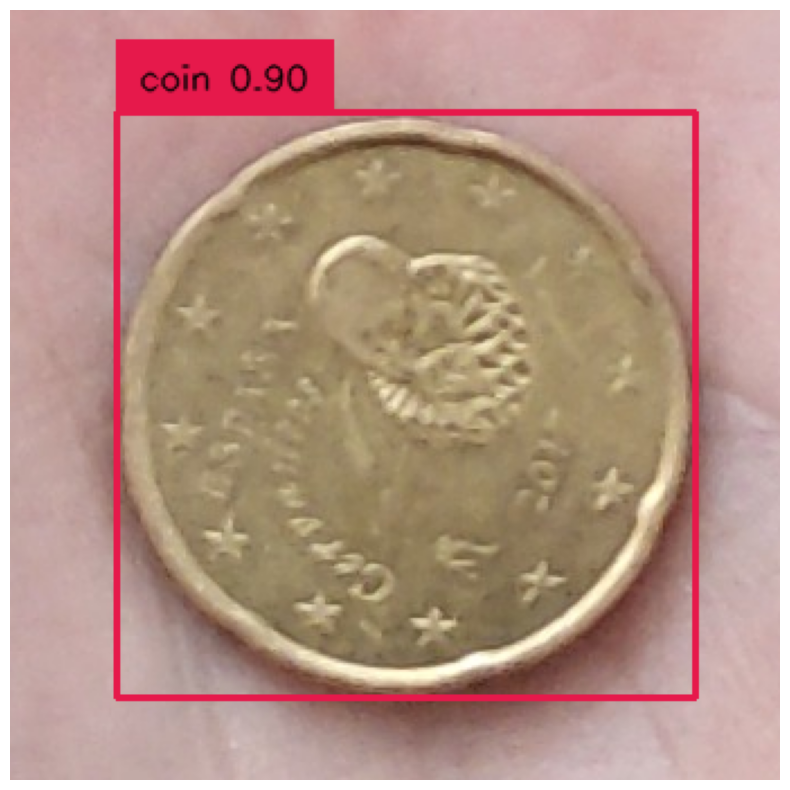

In [50]:
import cv2
import supervision as sv

# Load image
image = cv2.imread(SOURCE_IMAGE_PATH)

# Detect objects
detections = grounding_dino_model.predict_with_classes(
    image=image,
    classes=enhance_class_name(class_names=CLASSES),
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

# Annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_frame = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_frame, (10, 10))

### Prompting SAM with detected boxes

In [46]:
import numpy as np
from segment_anything import SamPredictor


def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=True
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

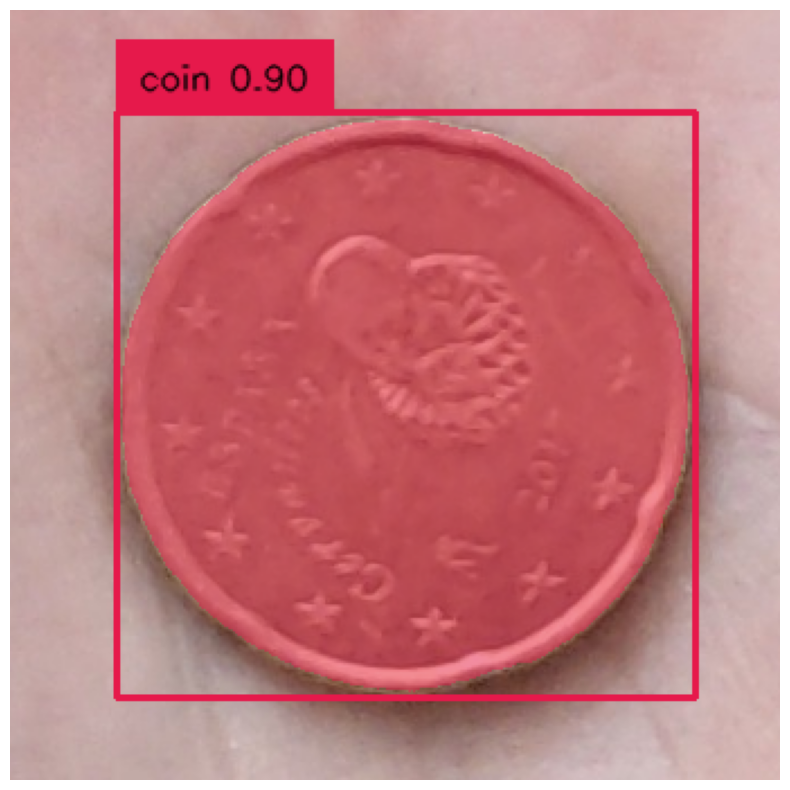

In [51]:
import cv2

# Convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)

# Annotate image with detections
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
labels = [
    f"{CLASSES[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections]
annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(annotated_image, (10, 10))

## Full dataset mask annotation

In [55]:
import os

IMAGES_DIRECTORY = PATH
IMAGES_EXTENSIONS = ['jpg', 'jpeg', 'png']

CLASSES = ['coin']
BOX_TRESHOLD = 0.30
TEXT_TRESHOLD = 0.25

### Extract labels from images

In [56]:
import cv2
import numpy as np
from tqdm.notebook import tqdm

images = {}
annotations = {}

image_paths = sv.list_files_with_extensions(
    directory=IMAGES_DIRECTORY,
    extensions=IMAGES_EXTENSIONS)

for image_path in tqdm(image_paths):
    image_name = image_path.name
    image_path = str(image_path)
    image = cv2.imread(image_path)

    detections = grounding_dino_model.predict_with_classes(
        image=image,
        classes=enhance_class_name(class_names=CLASSES),
        box_threshold=BOX_TRESHOLD,
        text_threshold=TEXT_TRESHOLD
    )
    detections = detections[detections.class_id != None]
    detections.mask = segment(
        sam_predictor=sam_predictor,
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        xyxy=detections.xyxy
    )
    images[image_name] = image
    annotations[image_name] = detections

  0%|          | 0/150 [00:00<?, ?it/s]

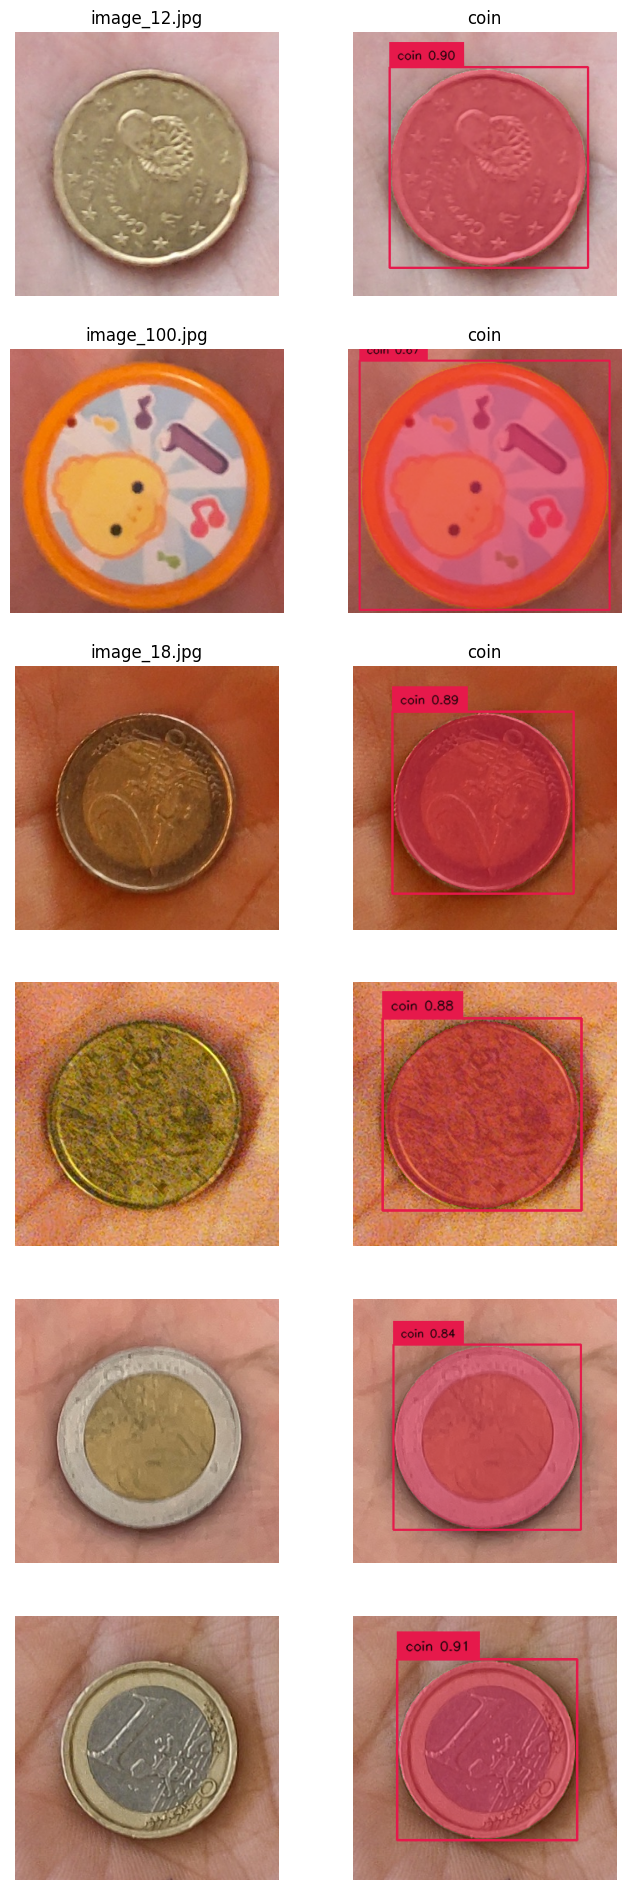

In [57]:
box_annotator = sv.BoxAnnotator()
mask_annotator = sv.MaskAnnotator()
num_samples = 6  # Number of samples to visualize
plot_images, plot_titles =  [], []
for i, (image_name, detections) in enumerate(annotations.items()):
    if i >= num_samples:
        break

    image = images[image_name]
    plot_images.append(image)
    plot_titles.append(image_name)

    labels = [
        f"{CLASSES[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _
        in detections]
    annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)
    plot_images.append(annotated_image)
    title = " ".join(set([
        CLASSES[class_id]
        for class_id
        in detections.class_id
    ]))
    plot_titles.append(title)

# Show N samples
num_samples_to_visualize = min(num_samples, len(annotations))
sv.plot_images_grid(
    images=plot_images[:2 * num_samples_to_visualize],
    titles=plot_titles[:num_samples_to_visualize],
    grid_size=(num_samples_to_visualize, 2),
    size=(2 * 4, num_samples_to_visualize * 4)
)


In [60]:
import cv2
import numpy as np


# Define the number of classes (excluding background)
num_classes = 1

# Initialize variables to store intersection and union for each class
intersection = np.zeros(num_classes, dtype=np.float32)
union = np.zeros(num_classes, dtype=np.float32)
iou_list=[]
# Loop through each image and its associated detections
for image_name, detections in annotations.items():
    img=cv2.imread(os.path.join(HOME,"public_coin_dataset_filtered/labels/",image_name.replace("image", "label")),cv2.IMREAD_GRAYSCALE)
    mask_image = detections.mask

    ground_truth_mask = (img > 0).astype(np.uint8)
    predicted_mask = (mask_image > 0).astype(np.uint8)
    # Calculate the intersection and union of the predicted and ground truth masks
    intersection = np.logical_and(predicted_mask, ground_truth_mask)
    union = np.logical_or(predicted_mask, ground_truth_mask)

    # Calculate the IoU (Intersection over Union) for each pixel
    iou = np.sum(intersection) / np.sum(union)

    # If you have multiple samples, calculate the mIoU by averaging the IoU values
    iou_list.append(iou)

print(f"mIoU: {np.round(np.mean(iou_list)*100,2)} %")



mIoU: 96.04 %


# Conclusions

This zero-shot pipeline based on 2D bounding boxes proposal + semantic + prompt works fine for this case.

As an improvement, SAM can bit fine-tunned or adjusted for a softer border segmentation.

